In [12]:
import os
import docvision as dv
import docgenpipe as dg
import docdataset as dd
from models.qwenvl import QwenVL2_LLM

In [13]:
cd /root/ucu-mt

/root/ucu-mt


/opt/conda/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
dataset = dd.download_dataset()

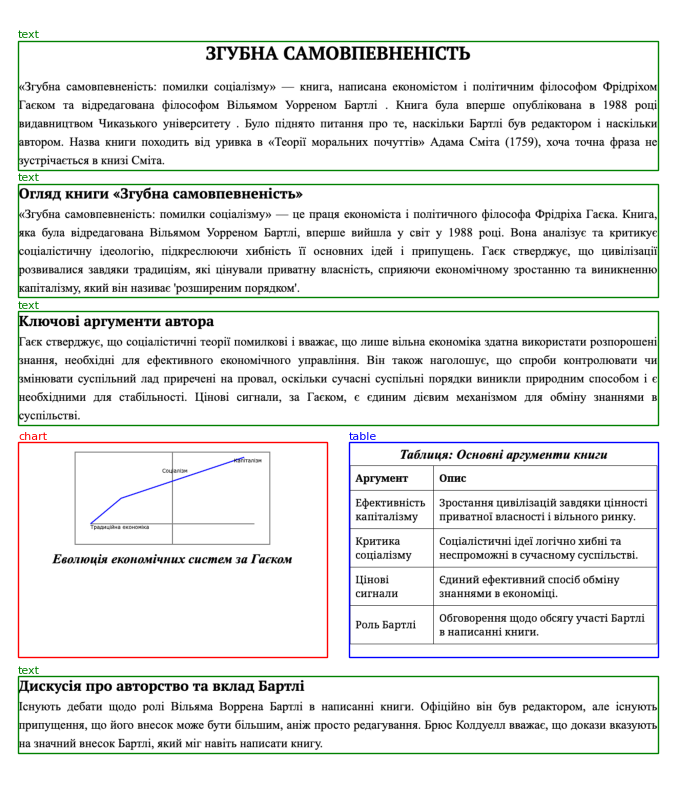

In [100]:
example = dataset["train"][-1]
dv.visualize_grounding(example.get("image"), example["grounding"])

## Qwen2-VL Original

In [7]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

In [10]:
device = torch.device('cuda')
model_name = 'Qwen/Qwen2-VL-7B-Instruct'
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name, torch_dtype="auto", device_map="auto", trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
prompt = 'Витягни текс кожного розділу із зображення послідовно'
conversation = [
    {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": prompt}]}
]
image = example.get("image")
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(text=[text_prompt], images=[image], padding=True, return_tensors="pt").to(device)

output_ids = model.generate(**inputs, max_new_tokens=256)

generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

## Qwen2-VL Unsloth

In [33]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs

/tmp/ipykernel_12029/874197143.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel # FastLanguageModel for LLMs


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [34]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Qwen2_Vl patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [129]:
image = example.get("image")

In [46]:
example.get("grounding")[0]['box']

{'l': 0.01171875,
 't': 0.05735153256704981,
 'r': 0.48046875,
 'b': 0.40313697318007663}

In [63]:
import numpy as np
img = np.array(image)

In [128]:
img.shape

(1633, 1280, 3)

In [79]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Витягни текст кожного розділу послідовно"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### ЗАЦІКАВЛЕНІ СТОРОНИ

Зацікавлені сторони, зацікавлені особи, заінтересовані сторони, причетні сторони (від англ. stakeholders) — фізичні та юридичні особи, які мають легітимний інтерес у діяльності організації, тобто певною мірою залежать від неї або можуть впливати на її діяльність. Іноді в літературі зустрічаються назви групи інтересів або групи впливу. Зацікавлені сторони забезпечують можливості для системи та є джерелом вимог до неї. У системній інженерії зацікавлених осіб розглядають у контексті процесу прийняття рішень як людей або організації, які залежать від результатів прийнятих рішень. Розуміння того, хто є зацікавленою стороною відносно до рішень, що приймаються, має бути виявленим заздалегідь. Часто це не відбувається — зацікавлені особи не виявляють себе до прийняття рішень. Однак, щойно рішення буде оголошене/реалізоване, всі, кого хоч якось воно зачіпає, висловлять свою думку.

### ОГЛЯД ЗАЦІКАВЛЕНІХ СТОРОН

Зацікавлені сторони або заінтересовані особи – це фізичні 

## Llama 3.2 11B Vision

In [106]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Mllama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


In [110]:
import torch._dynamo
torch._dynamo.config.capture_scalar_outputs = True

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Retrieve the text from the image in original language"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### Pixtral

In [127]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Llava patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: llava does not support SDPA - switching to eager!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Витягни текст кожного розділу послідовно"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

## Release Memory

In [ ]:
import torch
del model, tokenizer, 
torch.cuda.empty_cache()

In [125]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [119]:
for var in dir():
    if isinstance(eval(var), torch.Tensor):
        del globals()[var]
torch.cuda.empty_cache()

In [126]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Mar 18 00:34:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:09:00.0 Off |                  N/A |
|  0%   32C    P8             19W /  350W |     504MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [124]:
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")
print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024 / 1024:.2f} MB")

Memory allocated: 7608.62 MB
Memory reserved: 8104.00 MB
